<a href="https://colab.research.google.com/github/tevfik-erkut/ML_mixture/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
import statsmodels.api as sm
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


I will take a sample of last 1000 rows for train my model.

In [4]:
warnings.filterwarnings('ignore')
df = pd.read_csv("/content/spy.csv")
df.Date = pd.to_datetime(df.Date)
df = df[-1000:]

I will build my model to predict Close Prices of related stock

In [5]:
df_forecast = df.sort_values("Date")
df_forecast = df_forecast.set_index("Date")
df_forecast = df_forecast['Close'].to_frame()
df_forecast

,Close
Date,
2017-01-06,227.210007
2017-01-09,226.460007
2017-01-10,226.460007
2017-01-11,227.100006
2017-01-12,226.529999
...,...
2020-12-18,369.179993
2020-12-21,367.859985
2020-12-22,367.239990


Let's make a stationary test! 

In [6]:
from statsmodels.tsa.stattools import adfuller

X = df_forecast.Close
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.276903
p-value: 0.639672


Null hyphotesis of Augmented Dicker Fuller says the series are not stationary. And we dont have enough evidence to reject h0 hypothesis with %95 because p-value is above 0.05. In other words, this dataset is not stationary. Therefore I will apply difference method.

Now, It's time for plotting decompositions!

<Figure size 1080x1080 with 0 Axes>

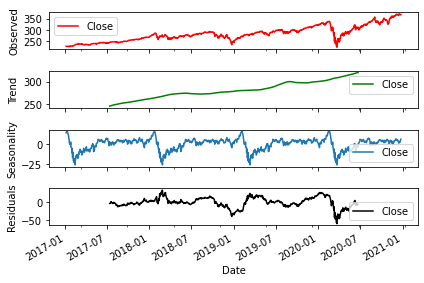

In [7]:
result = seasonal_decompose(df_forecast, freq = 260)
plt.figure(figsize = (15,15))
fig, axes = plt.subplots(4, 1, sharex=True)

result.observed.plot(ax = axes[0], color='r')
axes[0].set_ylabel('Observed')

result.trend.plot(ax = axes[1], color='g')
axes[1].set_ylabel('Trend')

result.seasonal.plot(ax = axes[2])
axes[2].set_ylabel('Seasonality')

result.resid.plot(ax = axes[3], color='k')
axes[3].set_ylabel('Residuals')
plt.tight_layout()

Let's move on to modelling part

In [34]:
X = df_forecast.values
size = int(len(X) * 0.9)
train, test = df_forecast[0:size], df_forecast[size:len(X)]

## ARMA Model

In [61]:
from statsmodels.tsa.arima_model import ARIMA

ARMA_model = ARIMA(endog=train, order=(3, 0, 7))
results = ARMA_model.fit()
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  900
Model:                     ARMA(3, 7)   Log Likelihood               -2333.798
Method:                       css-mle   S.D. of innovations              3.225
Date:                Sat, 09 Jul 2022   AIC                           4691.595
Time:                        17:11:01   BIC                           4749.224
Sample:                             0   HQIC                          4713.610
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         276.4395     17.829     15.505      0.000     241.495     311.384
ar.L1.Close    -0.5508      0.062     -8.908      0.000      -0.672      -0.430
ar.L2.Close     0.7490      0.030     25.304    

In [62]:
forecasted_values = results.predict(start=900, end=999)

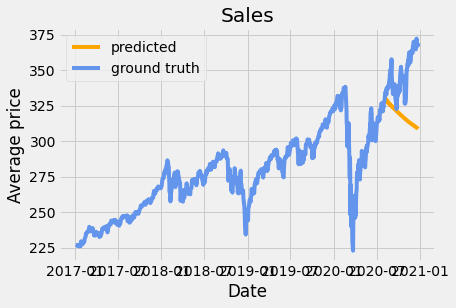

In [63]:
plt.plot(test.index, forecasted_values, color='orange', label='predicted')
plt.plot(df_forecast.index, df_forecast, color='cornflowerblue', label='ground truth')

plt.legend(loc='best')
plt.title(f'Sales')
plt.xlabel('Date')
plt.ylabel('Average price')
plt.show()

ARMA model has predicted a drop in price. It's quite clear that using ARMA model would not be a good option, I'm afraid.

## SARIMA

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Text(0, 0.5, 'Volume')

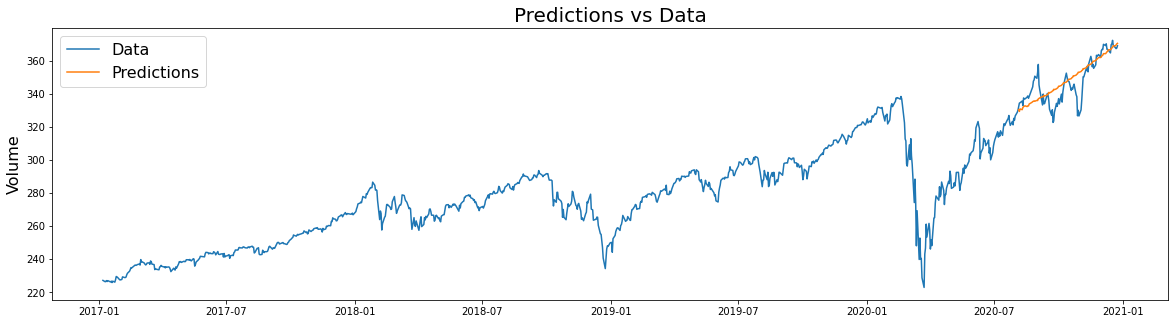

In [10]:
mod = SARIMAX(train,
            order=(9, 3, 8),
            seasonal_order=(2, 1, 10, 5),
            enforce_stationarity=False,
            enforce_invertibility=False)
results = mod.fit()

predictions = results.forecast(len(test))
predictions = pd.DataFrame(predictions).set_index(test.index).iloc[:,0]
plt.figure(figsize=(20,5))

plt.plot(df_forecast)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Predictions vs Data', fontsize=20)
plt.ylabel('Volume', fontsize=16)

After trying many combinations for p d q m parameters, the result is like this. Our SARIMA model has predicted an upwards trend.

## META - PROPHET

In [17]:
df_forecast= df[["Date", "Close"]]
df_forecast.columns = ["date", "Close"]
df_forecast.date = pd.to_datetime(df_forecast.date)
df_forecast = df_forecast.set_index("date")
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_forecast, label='Close')

features_and_target = pd.concat([X, y], axis=1)

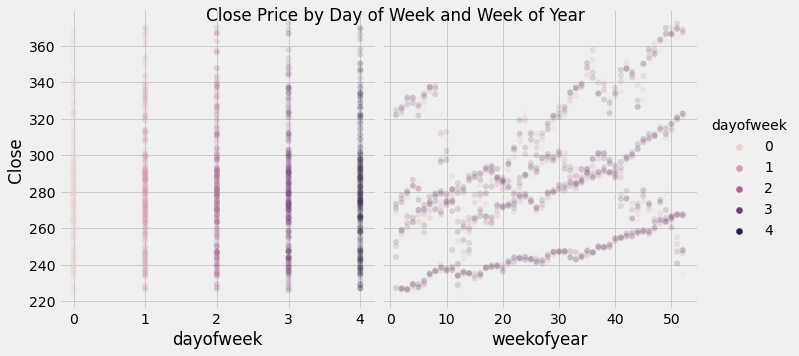

In [22]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
sns.pairplot(features_and_target.dropna(),
             hue='dayofweek',
             x_vars=['dayofweek',
                     'weekofyear'],
             y_vars='Close',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Close Price by Day of Week and Week of Year')
plt.show()
plt.style.use('fivethirtyeight') # For plots

In [23]:
split_date = '01-Mar-2020'
pjme_train = df_forecast.loc[df_forecast.index <= split_date].copy()
pjme_test = df_forecast.loc[df_forecast.index > split_date].copy()
from fbprophet import Prophet
model = Prophet(weekly_seasonality = True)
model.fit(pjme_train.reset_index() \
              .rename(columns={'date':'ds',
                               'Close':'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

In [25]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-02,322.325851,323.233736,333.848957,322.325851,322.325851,6.350741,6.350741,6.350741,-2.128873,-2.128873,-2.128873,8.479614,8.479614,8.479614,0.0,0.0,0.0,328.676592
1,2020-03-03,322.427678,323.029851,334.894643,322.427678,322.427678,6.488555,6.488555,6.488555,-1.829857,-1.829857,-1.829857,8.318412,8.318412,8.318412,0.0,0.0,0.0,328.916233
2,2020-03-04,322.529505,323.346868,334.129846,322.529505,322.529505,6.257839,6.257839,6.257839,-1.882775,-1.882775,-1.882775,8.140614,8.140614,8.140614,0.0,0.0,0.0,328.787344
3,2020-03-05,322.631332,323.380041,334.102757,322.631332,322.631332,6.115067,6.115067,6.115067,-1.832246,-1.832246,-1.832246,7.947313,7.947313,7.947313,0.0,0.0,0.0,328.746399
4,2020-03-06,322.733159,323.154404,334.015863,322.733159,322.733159,5.903320,5.903320,5.903320,-1.836478,-1.836478,-1.836478,7.739798,7.739798,7.739798,0.0,0.0,0.0,328.636479


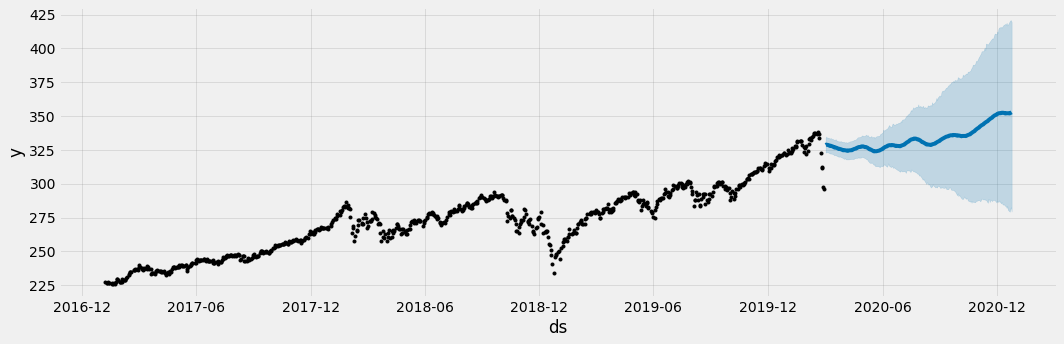

In [26]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

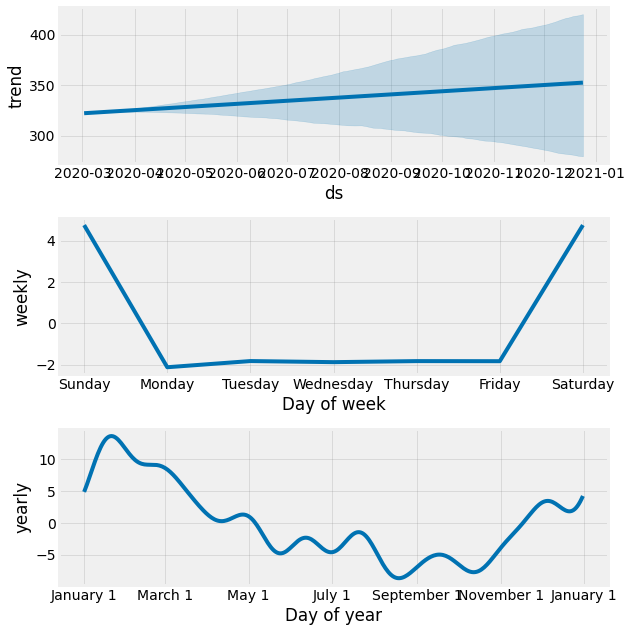

In [27]:
fig = model.plot_components(pjme_test_fcst)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

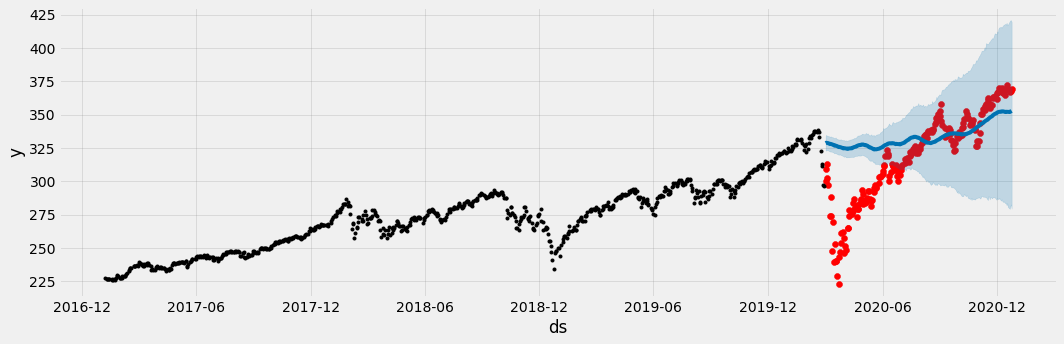

In [28]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['Close'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

In [29]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
1151,2021-02-23
1152,2021-02-24
1153,2021-02-25
1154,2021-02-26
1155,2021-02-27


In [30]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1151,2021-02-23,366.072377,270.356768,451.750923
1152,2021-02-24,366.084307,268.805508,452.322019
1153,2021-02-25,366.185010,267.522891,452.185063
1154,2021-02-26,366.214771,266.960950,454.996771
1155,2021-02-27,372.823090,272.672893,458.490966


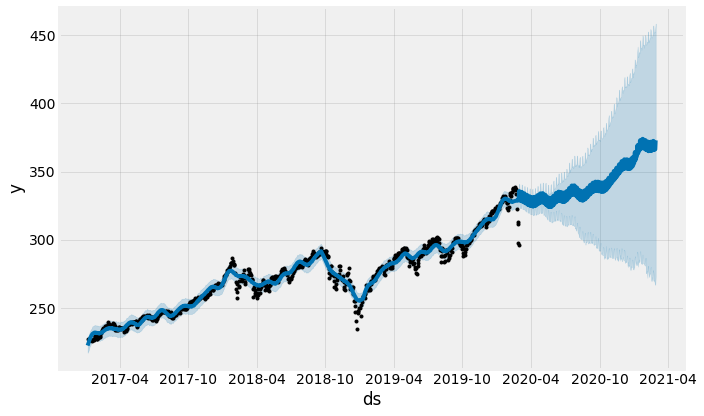

In [31]:

2
# Python
fig1 = model.plot(forecast)


In [33]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)